In [57]:
import time
import numpy
import matplotlib.pyplot as plt
from matplotlib import cm

### Papers

[Advances in Gaussian random field generation: a review](https://link.springer.com/content/pdf/10.1007/s10596-019-09867-y.pdf)

### Build mesh - material points

In [58]:
def build_material_point_coordinates(dx, n_div_x, n_div_y):
    
    nodal_coordinates = numpy.zeros([n_div_x * n_div_y, 2])
    counter = 0
    
    for i_y in range(n_div_y):      # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            nodal_coordinates[counter, 0] = coord_x
            nodal_coordinates[counter, 1] = coord_y
            counter += 1
            
    print("Number of nodes:", numpy.shape(nodal_coordinates)[0])
            
    return nodal_coordinates

Number of nodes: 2500


(-0.02475, 0.51975, -0.006, 0.126)

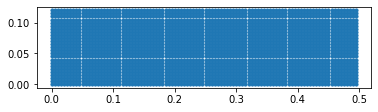

In [59]:
nodal_coords = build_material_point_coordinates(5e-3, 100, 25)
plt.scatter(nodal_coords[:, 0], nodal_coords[:, 1], s=10)
plt.axis('scaled') 

### Random field - parameters

In [68]:
mean_fc = 42.3           # Mean value of the random field (compressive strength MPa)
std_deviation = 5        # Standard deviation of the random field TODO: rename (this is an existing function)
threshold = 0.5          # Threshold value for the correlation function
correlation_length = 1   # Robin van der Have (2015) recommends that the correlation length is set to 1m

### Matrix decomposition method

In [61]:
def build_correlation_matrix(mesh, c1, lc):
    
    correlation_mat = numpy.zeros([len(mesh), len(mesh)])
    
    for i in range(len(mesh)):
        for j in range(i+1):
            correlation_mat[i, j] = c1 + (1 - c1) * numpy.exp(-numpy.linalg.norm(mesh[i, :] - mesh[j, :]) / lc)
            correlation_mat[j, i] = correlation_mat[i, j]
    
    return correlation_mat

In [62]:
def build_log_normal_distribution(std_dev, mean, correlation_mat):
    
    std_norm = numpy.sqrt(numpy.log(1 + std_dev / mean)**2)
    correlation_mat = (numpy.exp(correlation_mat * std_norm**2) - 1) / (numpy.exp(std_norm**2) - 1)
    plt.imshow(correlation_mat)
    
    return correlation_mat

In [63]:
def decompose_correlation_matrix(correlation_mat, mean, std_dev):
    
    eigenvalues, eigenvectors = numpy.linalg.eig(correlation_mat)
    L = eigenvectors * numpy.sqrt(numpy.absolute(eigenvalues))
    RV = numpy.random.uniform(low=0.0, high=1.0, size=[len(correlation_mat)])
    correlated_random_variables = mean + (numpy.matmul(L, RV) * std_dev)

    return correlated_random_variables


In [64]:
def build_correlated_random_variables(mesh, c1, lc, mean, std_dev):
    
    correlation_mat = build_correlation_matrix(mesh, c1, lc)
    correlation_mat = build_log_normal_distribution(std_dev, mean, correlation_mat)
    CRV = decompose_correlation_matrix(correlation_mat, mean, std_dev)
    
    return CRV

Time: 25.40778690100001


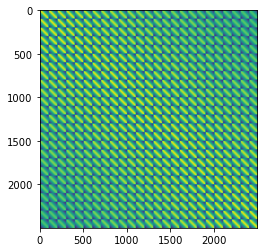

In [69]:
t0 = time.perf_counter()
crv = build_correlated_random_variables(nodal_coords, threshold, correlation_length, mean_fc, std_deviation)
t1 = time.perf_counter()
print("Time:", t1-t0)

(array([ 25.,  66., 103., 241., 368., 489., 551., 421., 195.,  41.]),
 array([36.14778044, 36.76139607, 37.3750117 , 37.98862733, 38.60224296,
        39.21585859, 39.82947422, 40.44308985, 41.05670548, 41.67032111,
        42.28393674]),
 <BarContainer object of 10 artists>)

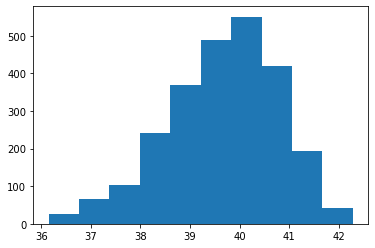

In [66]:
plt.hist(crv)

(-0.02475, 0.51975, -0.006, 0.126)

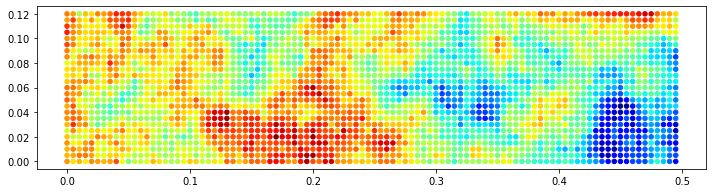

In [67]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(nodal_coords[:,0], nodal_coords[:,1], s=20, 
           c=crv, marker = 'o', cmap = cm.jet );
plt.axis('scaled') 